<a href="https://colab.research.google.com/github/Yisahak/Yisahak/blob/main/Microwave_Network_Fault_prediction_LSTM_GRU_time_series2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import all necessary libraries.
import numpy as np
import pandas as pd
from sklearn  import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import seaborn as sns
sns.set_theme()

In [2]:
# Hyper parameters
########
num_of_feature = 11 # number of input features for LSTM and GRU network
past_observation = 72 # Number of past hours data used as input to the LSTM and GRU network
##########

######## Model Parameters # 
hidden_layers_unit = [128, 64,32,16]
return_sequence = [True, True, True,False]
batch_size = 64
num_of_epoch = 50



# Read dataset

In [3]:
# Import Dataset

traffic_data = pd.read_csv("/content/MW_LOG_111.csv")
traffic_data = traffic_data.set_index(pd.DatetimeIndex(traffic_data['Date'])).rename(columns={"Date": "ds"})
traffic_data['ds'] = pd.to_datetime(traffic_data['ds'],infer_datetime_format=True)

In [4]:
traffic_data.head()

,ds,Fault_Type,Severity_id,RTN_id,OptiX RTN 905,OptiX RTN 980,OptiX RTN 950A,OptiX RTN 380A,OptiX RTN 380AX,year,month,week_day
Date,,,,,,,,,,,,
2022-11-10 15:49:00,2022-11-10 15:49:00,1,3,146,0,0,1,0,0,2022,11,3
2022-11-10 15:49:00,2022-11-10 15:49:00,5,3,640,0,0,1,0,0,2022,11,3
2022-11-10 15:51:00,2022-11-10 15:51:00,6,3,1349,0,0,1,0,0,2022,11,3
2022-11-10 15:52:00,2022-11-10 15:52:00,2,1,688,1,0,0,0,0,2022,11,3
2022-11-10 15:53:00,2022-11-10 15:53:00,1,3,19,0,0,1,0,0,2022,11,3


In [5]:
traffic_data = traffic_data.drop_duplicates()

In [6]:
# Checking for any missing or empty value
traffic_data.isna().sum()

ds                 0
Fault_Type         0
Severity_id        0
RTN_id             0
OptiX RTN 905      0
OptiX RTN 980      0
OptiX RTN 950A     0
OptiX RTN 380A     0
OptiX RTN 380AX    0
year               0
month              0
week_day           0
dtype: int64

In [7]:
traffic_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101313 entries, 2022-11-10 15:49:00 to 2023-03-31 23:49:00
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ds               101313 non-null  datetime64[ns]
 1   Fault_Type       101313 non-null  int64         
 2   Severity_id      101313 non-null  int64         
 3   RTN_id           101313 non-null  int64         
 4   OptiX RTN 905    101313 non-null  int64         
 5   OptiX RTN 980    101313 non-null  int64         
 6   OptiX RTN 950A   101313 non-null  int64         
 7   OptiX RTN 380A   101313 non-null  int64         
 8   OptiX RTN 380AX  101313 non-null  int64         
 9   year             101313 non-null  int64         
 10  month            101313 non-null  int64         
 11  week_day         101313 non-null  int64         
dtypes: datetime64[ns](1), int64(11)
memory usage: 10.0 MB


In [8]:
traffic_data.describe()

,Fault_Type,Severity_id,RTN_id,OptiX RTN 905,OptiX RTN 980,OptiX RTN 950A,OptiX RTN 380A,OptiX RTN 380AX,year,month,week_day
count,101313.000000,101313.000000,101313.000000,101313.000000,101313.000000,101313.000000,101313.000000,101313.000000,101313.000000,101313.000000,101313.000000
mean,3.797519,2.369232,795.163928,0.430083,0.105939,0.462567,0.000957,0.000454,2022.950480,2.666992,4.062322
std,2.579669,0.839013,503.721550,0.495090,0.307761,0.498599,0.030928,0.021303,0.216952,2.140841,1.795068
min,0.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022.000000,1.000000,1.000000
25%,1.000000,2.000000,241.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2023.000000,2.000000,3.000000
50%,4.000000,3.000000,808.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2023.000000,2.000000,4.000000
75%,6.000000,3.000000,1269.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2023.000000,3.000000,6.000000
max,9.000000,3.000000,1656.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2023.000000,12.000000,7.000000


<Axes: xlabel='Date'>

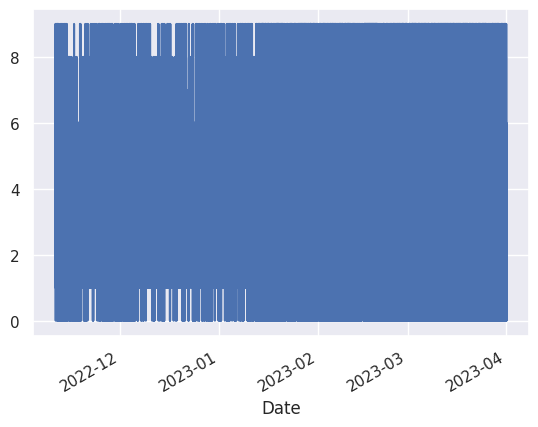

In [9]:
#traffic_data['temp'].plot()
traffic_data['Fault_Type'].plot()


<Axes: xlabel='Date'>

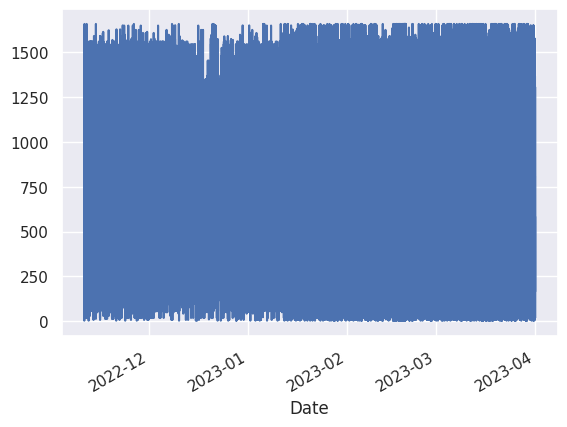

In [10]:
traffic_data['RTN_id'].plot()

In [11]:
split_date = '2022-12-01'
train_data = traffic_data.loc[traffic_data.index <= split_date].copy()
test_data = traffic_data.loc[traffic_data.index > split_date].copy()

train_time = train_data["ds"]
test_time = test_data["ds"]

In [12]:
def plot_series(time, series, format='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end],format)
    plt.xlabel('Time')
    plt.ylabel('Fault_Type')
    plt.grid(True)

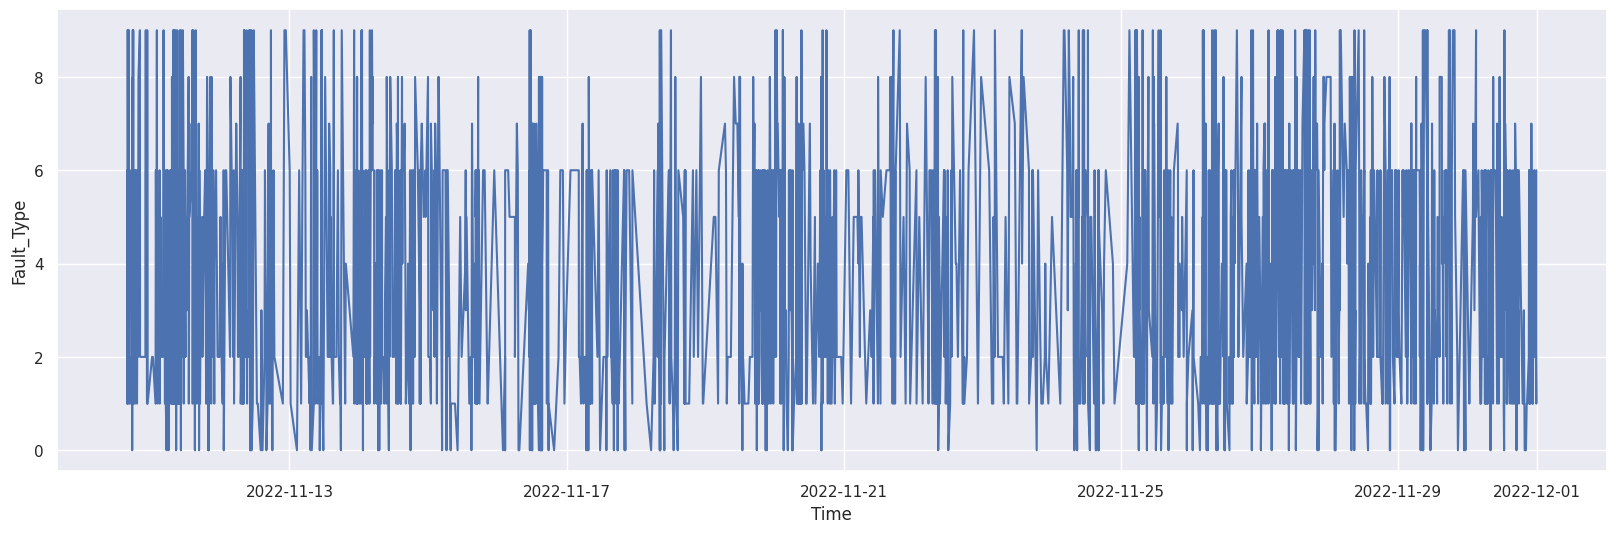

In [13]:
x_train = np.array(train_data['Fault_Type'])
x_valid = np.array(test_data['Fault_Type'])

time_train = np.array(train_time)
time_valid = np.array(test_time)

plt.figure(figsize=(20,6))
plot_series(time_train, x_train)
plt.savefig('Fault_Analyisis.png')

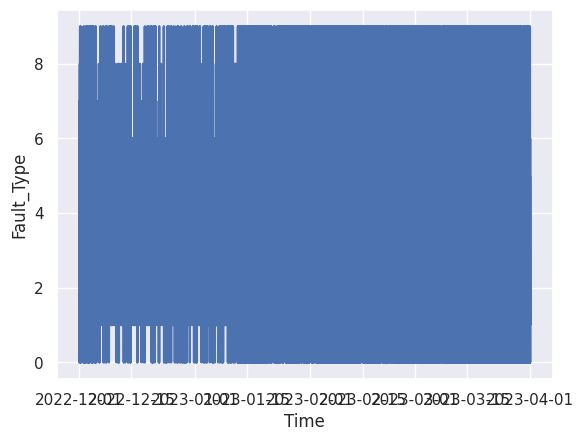

In [14]:
plot_series(time_valid, x_valid)

In [15]:
train_data_without_ds = train_data.drop(columns=['ds'])
train_data_without_ds
test_data_without_ds = test_data.drop(columns=['ds'])
test_data_without_ds

,Fault_Type,Severity_id,RTN_id,OptiX RTN 905,OptiX RTN 980,OptiX RTN 950A,OptiX RTN 380A,OptiX RTN 380AX,year,month,week_day
Date,,,,,,,,,,,
2022-12-01 00:01:00,1,3,76,1,0,0,0,0,2022,12,3
2022-12-01 00:14:00,0,3,76,1,0,0,0,0,2022,12,3
2022-12-01 00:24:00,0,3,995,0,0,1,0,0,2022,12,3
2022-12-01 00:31:00,0,3,838,0,0,1,0,0,2022,12,3
2022-12-01 00:39:00,0,3,807,0,0,1,0,0,2022,12,3
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31 23:27:00,6,3,966,0,0,1,0,0,2023,3,4
2023-03-31 23:49:00,6,3,808,1,0,0,0,0,2023,3,4
2023-03-31 23:49:00,2,1,966,1,0,0,0,0,2023,3,4


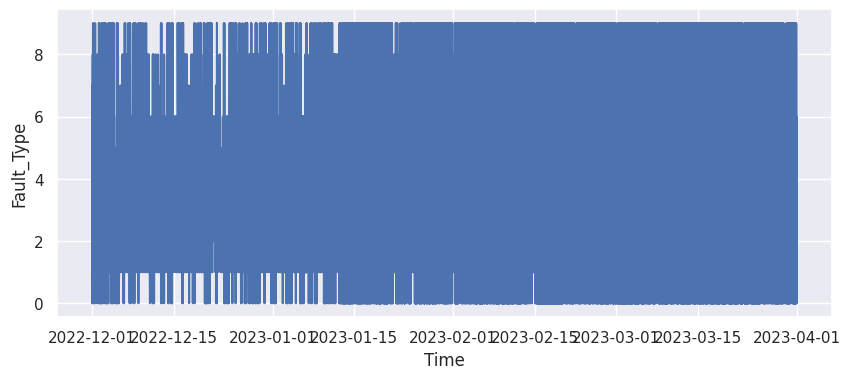

In [16]:
x_train = np.array(train_data['Fault_Type'])
x_valid = np.array(test_data['Fault_Type'])

time_train = np.array(train_data['ds'])
time_valid = np.array(test_data['ds'])

plt.figure(figsize=(10,4))
plot_series(time_valid, x_valid)

In [17]:
# Values of the attribute are in different scales. For example, holiday has maximum value 1 and traffic volume let say, 2000. Since these values are totally different range, it might be hurt model learning process. To overcome this issue, we need to do data normalization or standarization.
sc = MinMaxScaler()
sc_test = MinMaxScaler()
training_data_set = sc.fit_transform(train_data_without_ds)
training_data_frame = pd.DataFrame(training_data_set)
test_data_set = sc_test.fit_transform(test_data_without_ds)
test_data_frame = pd.DataFrame(test_data_set)

In [18]:
# Make data for the LSTM model. I used past t-hours of data to predict the next 'n' hours data. Here window_size means window size data will be used for predicting next 'n' hours data

def df_to_x_y(data, window_size=5):
    X = []
    y = []
    for i in range(len(data)-window_size):
        row = [r for r in data[i:i+window_size]]
        X.append(row)
        label = data[i+window_size][num_of_feature-1]
        y.append(label)
    return np.array(X), np.array(y)

X, y = df_to_x_y(training_data_set,past_observation)
X.shape, y.shape

((2277, 72, 11), (2277,))

In [19]:
# X test y Test
X_test, y_test = df_to_x_y(test_data_set, past_observation)
X_test.shape, y_test.shape

((98892, 72, 11), (98892,))

In [20]:
# split data into train test and validation datase
from cgi import test


train_length = int(len(X)*0.9) # 80% trainging
validation_length = int(len(X)*.10) # 10% testing and rest for validation
print(train_length, validation_length, (train_length+validation_length))
X_train, y_train = X[:train_length],y[:train_length]
X_val, y_val = X[train_length:], y[train_length:]

2049 227 2276


In [21]:
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)

(((2049, 72, 11), (2049,)), ((228, 72, 11), (228,)))

In [22]:
#define LSTM model:
import math

LSTM_Model = Sequential()
LSTM_Model.add(InputLayer((past_observation,num_of_feature)))
for i in range(len(hidden_layers_unit)):
    LSTM_Model.add(LSTM(hidden_layers_unit[i], return_sequences=return_sequence[i]))
LSTM_Model.add(Dense(1))
LSTM_Model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.mean_absolute_percentage_error])
LSTM_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 72, 128)           71680     
                                                                 
 lstm_1 (LSTM)               (None, 72, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 72, 32)            12416     
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 136,657
Trainable params: 136,657
Non-trainable params: 0
_________________________________________________________________


In [23]:
#Define GRU MODEL
GRU_Model = Sequential()
GRU_Model.add(InputLayer((past_observation,num_of_feature)))
for i in range(len(hidden_layers_unit)):
    GRU_Model.add(GRU(hidden_layers_unit[i], return_sequences=return_sequence[i]))
GRU_Model.add(Dense(1))
GRU_Model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.mean_absolute_percentage_error])
GRU_Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 72, 128)           54144     
                                                                 
 gru_1 (GRU)                 (None, 72, 64)            37248     
                                                                 
 gru_2 (GRU)                 (None, 72, 32)            9408      
                                                                 
 gru_3 (GRU)                 (None, 16)                2400      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 103,217
Trainable params: 103,217
Non-trainable params: 0
_________________________________________________________________


In [24]:
LSTM_CheckPoint = ModelCheckpoint('model/model_lstm/', save_best_only=True)
GRU_CheckPoint = ModelCheckpoint('model/model_gru/', save_best_only=True)
earlyStop =  tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, mode='min')

In [ ]:
# Train LSTM Model
LSTM_history = LSTM_Model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_of_epoch, callbacks=[LSTM_CheckPoint, earlyStop], batch_size=batch_size, verbose=1)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 0.1915 - mean_absolute_error: 0.3597 - mean_absolute_percentage_error: 27632868.0000

33/33 [==============================] - 44s 1s/step - loss: 0.1915 - mean_absolute_error: 0.3597 - mean_absolute_percentage_error: 27632868.0000 - val_loss: 0.1876 - val_mean_absolute_error: 0.4285 - val_mean_absolute_percentage_error: 190890896.0000
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 0.0573 - mean_absolute_error: 0.1889 - mean_absolute_percentage_error: 49429680.0000

33/33 [==============================] - 31s 960ms/step - loss: 0.0573 - mean_absolute_error: 0.1889 - mean_absolute_percentage_error: 49429680.0000 - val_loss: 0.0709 - val_mean_absolute_error: 0.2616 - val_mean_absolute_percentage_error: 119643648.0000
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.1137 - mean_absolute_percentage_error: 38756612.0000

33/33 [==============================] - 30s 922ms/step - loss: 0.0311 - mean_absolute_error: 0.1137 - mean_absolute_percentage_error: 38756612.0000 - val_loss: 0.0037 - val_mean_absolute_error: 0.0543 - val_mean_absolute_percentage_error: 28036754.0000
Epoch 4/50
33/33 [==============================] - ETA: 0s - loss: 0.0241 - mean_absolute_error: 0.0717 - mean_absolute_percentage_error: 31377826.0000

33/33 [==============================] - 27s 838ms/step - loss: 0.0241 - mean_absolute_error: 0.0717 - mean_absolute_percentage_error: 31377826.0000 - val_loss: 0.0031 - val_mean_absolute_error: 0.0493 - val_mean_absolute_percentage_error: 24454986.0000
Epoch 5/50
33/33 [==============================] - ETA: 0s - loss: 0.0224 - mean_absolute_error: 0.0723 - mean_absolute_percentage_error: 30071992.0000

In [ ]:
# Train GRU Model
GRU_history = GRU_Model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_of_epoch, callbacks=[GRU_CheckPoint, earlyStop], batch_size=batch_size, verbose=1)

In [ ]:
# summarize history for loss
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(LSTM_history.history['loss'], color='red')
ax[0].plot(LSTM_history.history['val_loss'], color='g')
ax[0].set_title('LSTM Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Training Loss', 'Validation Loss'], loc='upper right')

ax[1].plot(GRU_history.history['loss'], color='red')
ax[1].plot(GRU_history.history['val_loss'], color='g')
ax[1].set_title('GRU Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.savefig("training_loss.png", dpi=1200)
plt.show()

In [ ]:
# summarize history for loss
fig, ax = plt.subplots(2,2, figsize=(20,8))
ax[0][0].plot(LSTM_history.history['mean_absolute_error'], color='red')
ax[0][0].plot(LSTM_history.history['val_mean_absolute_error'], color='g')
ax[0][0].set_title('Mean Absolute Error (LSTM)')
ax[0][0].set_ylabel('Error')
ax[0][0].set_xlabel('Epoch')
ax[0][0].legend(['Training Error', 'Validation Error'], loc='upper right')

ax[0][1].plot(LSTM_history.history['mean_absolute_percentage_error'], color='red')
ax[0][1].plot(LSTM_history.history['val_mean_absolute_percentage_error'], color='g')
ax[0][1].set_title('Mean Absolute Percentatge Error (LSTM)')
ax[0][1].set_ylabel('Error')
ax[0][1].set_xlabel('Epoch')
ax[0][1].legend(['Training Error', 'Validation Error'], loc='upper right')


ax[1][0].plot(GRU_history.history['mean_absolute_error'], color='orangered')
ax[1][0].plot(GRU_history.history['val_mean_absolute_error'], color='firebrick')
ax[1][0].set_title('Mean Absolute Error (GRU)')
ax[1][0].set_ylabel('Loss')
ax[1][0].set_xlabel('Epoch')
ax[1][0].legend(['Training Loss', 'Validation Loss'], loc='upper right')

ax[1][1].plot(GRU_history.history['mean_absolute_percentage_error'], color='orangered')
ax[1][1].plot(GRU_history.history['val_mean_absolute_percentage_error'], color='firebrick')
ax[1][1].set_title('Mean Absolute Percentatge Error (GRU)')
ax[1][1].set_ylabel('Error')
ax[1][1].set_xlabel('Epoch')
ax[1][1].legend(['Training Error', 'Validation Error'], loc='upper right')
fig.tight_layout()
plt.savefig("mean_absolute_error_loss.png", dpi=600)
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
lstm_model = load_model('model/model_lstm/')
gru_model = load_model('model/model_gru/')

In [ ]:
lstm_prediction = lstm_model.predict(X_test)
gru_prediction = gru_model.predict(X_test)

In [ ]:
from tabnanny import verbose


lstm_evaluation = lstm_model.evaluate(X_test, y_test, verbose=0)
gru_evaluation = gru_model.evaluate(X_test, y_test, verbose=0)

In [ ]:
(lstm_evaluation, gru_evaluation)

In [ ]:
print(f'LSTM: Loss: {np.round(lstm_evaluation[0],4)}, Mean Absolute Error: {np.round(lstm_evaluation[1],4)}, MAPE: {np.round(lstm_evaluation[2],4)}')
print(f'GRU: Loss: {np.round(gru_evaluation[0],4)}, Mean Absolute Error: {np.round(gru_evaluation[1],4)}, MAPE: {np.round(gru_evaluation[2],4)}')

In [ ]:
lstm_Y = np.repeat(lstm_prediction, num_of_feature, axis=1)
lstm_y_inverse = sc_test.inverse_transform(lstm_Y)
gru_Y = np.repeat(gru_prediction, num_of_feature, axis=1)
gru_y_inverse = sc_test.inverse_transform(gru_Y)

In [ ]:
Y_test = np.repeat(y_test, num_of_feature)
Y_test = Y_test.reshape(-1,num_of_feature)
Y_Test_transfer = sc_test.inverse_transform(Y_test)

In [ ]:
lstm_Y_pred = lstm_y_inverse[:, num_of_feature-1]
gru_Y_pred = gru_y_inverse[:,num_of_feature-1]
actual_Y_test = Y_Test_transfer[:,num_of_feature-1 ]

In [ ]:
def plot_series(time, series_true, series_pred, format='-', start=0, end=None):
    plt.plot(time[start:end], series_true[start:end],format)
    plt.plot(time[start:end], series_pred[start:end],format)
    plt.xlabel('Time')
    plt.ylabel('Fault_Type')
    plt.grid(True)
    plt.show()

In [ ]:
lstm_y_pred = np.array(lstm_Y_pred)
gru_y_pred = np.array(gru_Y_pred)
y_true = np.array(actual_Y_test)

time_test = np.array(test_time)

plt.figure(figsize=(20,8))
plot_series(time_test[:], y_true[:50],lstm_y_pred[:50])
plt.figure(figsize=(20,8))
plot_series(time_test[:50], y_true[:50],gru_y_pred[:50])

In [ ]:
def plot_series_subplot(time, series_true, series_pred, ax,title="",format='-', start=0, end=None):
    xlabels = [str(time[i])[0:13] for i in range(len(time))]
    ax.plot(time[start:end], series_true[start:end],format)
    ax.plot(time[start:end], series_pred[start:end],format)
    ax.set_xlabel('Time')
    ax.set_title(title)
    #ax.set_xticks(time[start:end])
    ax.set_xticklabels(xlabels, rotation=50)
    ax.legend(['Actual','Predicted'], loc='best')
    ax.set_ylabel('Fault_Type')
    ax.grid(True)

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,8))
plot_series_subplot(time_test[:50], y_true[:50],lstm_y_pred[:50],ax[0][0], "LSTM Prediction")
#plt.figure(figsize=(20,8))
plot_series_subplot(time_test[:50], y_true[:50],gru_y_pred[:50], ax[0][1],"GRU Prediction")
plot_series_subplot(time_test[200:300], y_true[200:300],lstm_y_pred[200:300],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[200:300], y_true[200:300],gru_y_pred[200:300], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig("prediction.png", dpi=600)

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,8))
plot_series_subplot(time_test[1000:1200], y_true[1000:1200],lstm_y_pred[1000:1200],ax[0][0], "LSTM Prediction")
plot_series_subplot(time_test[1000:1200], y_true[1000:1200],gru_y_pred[1000:1200], ax[0][1],"GRU Prediction")

plot_series_subplot(time_test[0:500], y_true[0:500],lstm_y_pred[0:500],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[0:500], y_true[0:500],gru_y_pred[0:500], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig("prediction_1.png", dpi=1200)

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,8))
plot_series_subplot(time_test[50:80], y_true[50:80],lstm_y_pred[50:80],ax[0][0], "LSTM Prediction")
plot_series_subplot(time_test[50:80], y_true[50:80],gru_y_pred[50:80], ax[0][1],"GRU Prediction")

plot_series_subplot(time_test[100:120], y_true[100:120],lstm_y_pred[100:120],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[100:120], y_true[100:120],gru_y_pred[100:120], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig("prediction_2.png", dpi=600)

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,8))
plot_series_subplot(time_test[50:80], y_true[50:80],lstm_y_pred[50:80],ax[0][0], "LSTM Prediction")
plot_series_subplot(time_test[50:80], y_true[50:80],gru_y_pred[50:80], ax[0][1],"GRU Prediction")

plot_series_subplot(time_test[300:400], y_true[300:400],lstm_y_pred[300:400],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[300:400], y_true[300:400],gru_y_pred[300:400], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig("prediction_3.png", dpi=600)